In [1]:
import numpy as np
import pyldpc as ldpc
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from utils_f import load_code
import os
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
H_filename = 'source/BCH_63_45_3_strip.alist'
code = load_code(H_filename)
H = code.H
G = code.G
var_degrees = code.var_degrees
chk_degrees = code.chk_degrees
num_edges = code.num_edges
u = code.u
d = code.d
n = code.n
m = code.m
k = code.k

In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, num_iterations = 5, learnable = True):
        super(Decoder, self).__init__()
        if learnable == True:
            self.W_cv = torch.nn.Parameter((torch.ones((num_iterations, num_edges))))
            self.W_cv.requires_grad = True
            self.B_cv = torch.nn.Parameter((torch.zeros((num_iterations, num_edges))))
            self.B_cv.requires_grad = True
            self.W_vc = torch.nn.Parameter((torch.ones((num_iterations, num_edges))))
            self.W_vc.requires_grad = True
        else:
            self.W_cv = torch.ones((num_iterations, num_edges))
            self.B_cv = torch.zeros((num_iterations, num_edges))
            self.W_vc = torch.ones((num_iterations, num_edges))

        self.num_iterations = num_iterations
        
    def forward(self, soft_input):
        soft_input = soft_input.T           # TODO! Fix matrix dimensions inside functions
        # print(soft_input.shape)
        cv = torch.zeros((num_edges, soft_input.shape[1]))
        for iteration in range(0, self.num_iterations):
            vc = self.compute_vc(cv, soft_input, iteration)
            cv = self.compute_cv(vc, iteration)
            soft_input = self.marginalize(soft_input, cv)
        output = torch.sigmoid(-soft_input)
        output = output.T
        
        return output

        
    def compute_vc(self, cv, soft_input, iteration):
        edges = []
        for i in range(0, n):
            for j in range(0, var_degrees[i]):
                edges.append(i)
        # print(soft_input.shape, len(edges), edges)
        reordered_soft_input = torch.index_select(soft_input, 0, torch.tensor(edges).to(device))

        vc = torch.zeros((num_edges, cv.shape[1])).to(device)
        counter = 0
        edge_order = []

        for i in range(0, n): # for each variable node v
            for j in range(0, var_degrees[i]):
                edge_order.append(d[i][j])
                extrinsic_edges = []
                for jj in range(0, var_degrees[i]):
                    if jj != j: # extrinsic information only
                        extrinsic_edges.append(d[i][jj])
                # if the list of edges is not empty, add them up
                if extrinsic_edges:
                    # print(cv.shape, len(extrinsic_edges), extrinsic_edges)
                    temp = torch.index_select(cv.to(device), 0, torch.tensor(extrinsic_edges).to(device))
                    temp = torch.sum(temp, 0)
                else:
                    temp = torch.zeros(cv.shape[1])

                temp = temp.to(device)
                vc[counter] = temp
        
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.arange(0, num_edges)
        vc = torch.index_select(vc, 0, torch.tensor(new_order).to(device))
        vc += reordered_soft_input * torch.tile(torch.reshape(self.W_vc[iteration], (-1,1)), (1, cv.shape[1])).to(device)       # add soft inputs of the previous iterations!
        return vc 

    def compute_cv(self, vc, iteration):
        cv_list = []
        prod_list = []
        min_list = []
        edge_order = []
        for i in range(0, m): # for each check node c
            for j in range(0, chk_degrees[i]):
                edge_order.append(u[i][j])
                extrinsic_edges = []
                for jj in range(0, chk_degrees[i]):
                    if jj != j:
                        extrinsic_edges.append(u[i][jj])
                temp = torch.index_select(vc.to(device),0,torch.tensor(extrinsic_edges).to(device))
                temp1 = torch.prod(torch.sign(temp),0)
                temp2 = torch.min(torch.abs(temp),0)[0]
                prod_list.append(temp1)
                min_list.append(temp2)
        prods = torch.stack(prod_list)
        mins = torch.stack(min_list)
        mins = torch.relu(mins - torch.tile(torch.reshape(self.B_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device))
        cv = prods * mins
        new_order = np.zeros(num_edges).astype(int)
        new_order[edge_order] = np.array(range(0,num_edges)).astype(int)
        cv = torch.index_select(cv, 0, torch.tensor(new_order).to(device))
        cv = cv * torch.tile(torch.reshape(self.W_cv[iteration], (-1,1)), (1, vc.shape[1])).to(device)
        return cv

    # combine messages to get posterior LLRs
    def marginalize(self, soft_input, cv):
        weighted_soft_input = soft_input
        soft_output = []
        for i in range(0,n):
            edges = []
            for e in range(0,var_degrees[i]):
                edges.append(d[i][e])
            temp = torch.index_select(cv,0,torch.tensor(edges).to(device))
            temp = torch.sum(temp, 0)
            soft_output.append(temp)
        soft_output = torch.stack(soft_output)
        soft_output = weighted_soft_input + soft_output
        return soft_output

In [5]:
from tqdm.notebook import tqdm

def epoch_train(loader, clf, criterion, opt):
    clf.train(True)
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in tqdm(loader, desc='Train batch #', leave=False):
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        # print(model_input[0], model_output[0])
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
        # calculate grad, upd weights
        opt.zero_grad()
        loss.backward()
        opt.step()
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)
    return avg_loss, avg_acc

            
            
                        
def epoch_test(loader, clf, criterion):
    clf.eval()
    avg_loss = 0
    avg_acc = 0
    correct = 0
    # load batch
    for model_input, target in tqdm(loader, desc='Test batch #', leave=False):
        # move data to device
        model_input = model_input.to(device)
        target = target.to(device)
        # calculate outputs, loss and accuracy
        model_output = clf(model_input)
        loss = criterion(model_output, target)
        avg_loss += loss
        correct += torch.count_nonzero(torch.heaviside(model_output-0.5, torch.tensor([0.]).to(device)).to(device) == target)
    avg_loss = avg_loss / len(loader)
    avg_acc = correct / len(loader.dataset)

    return avg_loss, avg_acc

def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in trange(n_epochs):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(clf.W_cv[0,:5])
        if (np.mod(epoch+1,1)==0):
            print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
                  f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [6]:
from torch.utils.data import Dataset
import itertools    
    
class NoisyDataset(Dataset):
    def __init__(self, 
                 G=code.G,
                 H=code.H,
                 SNR=2, 
                 zero_cw=True, 
                 set_size = 1024):

        self.G = torch.tensor(G)
        self.SNR = SNR
        self.zero_cw = zero_cw
        self.set_size = set_size

        self.sigma = torch.sqrt(torch.tensor(1)/(2*10**((self.SNR + 10*torch.log10(torch.tensor(code.k/code.n)))/10)))

        
        if self.zero_cw:
            # Train on zero-codewords
            self.codewords = torch.ones((self.set_size, code.n))
        else:
            # Create a set of random information words of size == self.set_size
            self.codewords = torch.randint(high=2, size=(self.set_size,code.k)) @ self.G % 2
        
    def __len__(self):
        return len(self.codewords)
    
    def __getitem__(self, idx):
        noise = self.sigma * torch.randn(code.n)
        modulated = self.modulateBPSK(self.codewords[idx])
        noisy_cw = modulated + noise
        return noisy_cw, self.codewords[idx]
    
    def modulateBPSK(self, x):
        return -2*x +1
    

In [7]:
from torch.utils.data import DataLoader


dataset = NoisyDataset()


batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset, batch_size=len(dataset))

In [8]:
num_iterations = 5
decoder = Decoder(num_iterations=num_iterations).to(device)
ms = Decoder(num_iterations=num_iterations, learnable=False).to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(decoder.parameters())


verbose = True
for epoch in tqdm(range(30), desc='Epoch'): 
    train_loss, train_acc = epoch_train(train_dataloader, decoder, loss_fn, optimizer)
    test_loss, test_acc = epoch_test(test_dataloader, decoder, loss_fn)

    if verbose:
        print(f'Train loss: {train_loss:10.2f}\tTrain acc: {train_acc:4.2f}')
        print(f'Test loss:  {test_loss:10.2f}\tTest acc:  {test_acc:4.2f}')
        print()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       1.04	Train acc: 56.85
Test loss:        1.05	Test acc:  56.99



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       1.06	Train acc: 57.08
Test loss:        0.93	Test acc:  57.41



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.99	Train acc: 57.08
Test loss:        0.90	Test acc:  57.29



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.95	Train acc: 57.04
Test loss:        0.93	Test acc:  57.17



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.95	Train acc: 57.10
Test loss:        0.96	Test acc:  57.03



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.88	Train acc: 57.13
Test loss:        0.95	Test acc:  57.02



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.95	Train acc: 57.10
Test loss:        0.81	Test acc:  57.14



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.88	Train acc: 57.18
Test loss:        0.85	Test acc:  57.28



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.91	Train acc: 57.27
Test loss:        0.80	Test acc:  57.07



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.88	Train acc: 57.21
Test loss:        0.81	Test acc:  57.10



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.84	Train acc: 57.27
Test loss:        0.74	Test acc:  57.53



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.80	Train acc: 57.32
Test loss:        0.77	Test acc:  57.31



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.80	Train acc: 57.38
Test loss:        0.78	Test acc:  57.32



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.74	Train acc: 57.29
Test loss:        0.75	Test acc:  57.22



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.75	Train acc: 57.38
Test loss:        0.77	Test acc:  57.24



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.75	Train acc: 57.19
Test loss:        0.71	Test acc:  57.30



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.70	Train acc: 57.42
Test loss:        0.71	Test acc:  57.38



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.71	Train acc: 57.50
Test loss:        0.65	Test acc:  57.40



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.70	Train acc: 57.45
Test loss:        0.68	Test acc:  57.59



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.69	Train acc: 57.26
Test loss:        0.66	Test acc:  57.27



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.65	Train acc: 57.43
Test loss:        0.65	Test acc:  57.58



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.66	Train acc: 57.39
Test loss:        0.61	Test acc:  57.44



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.61	Train acc: 57.31
Test loss:        0.60	Test acc:  57.49



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.63	Train acc: 57.66
Test loss:        0.58	Test acc:  57.40



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.61	Train acc: 57.45
Test loss:        0.54	Test acc:  57.45



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.57	Train acc: 57.46
Test loss:        0.58	Test acc:  57.40



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.56	Train acc: 57.47
Test loss:        0.56	Test acc:  57.60



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.49	Train acc: 57.68
Test loss:        0.55	Test acc:  57.53



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.53	Train acc: 57.44
Test loss:        0.51	Test acc:  57.62



Train batch #:   0%|          | 0/8 [00:00<?, ?it/s]

Test batch #:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss:       0.52	Train acc: 57.62
Test loss:        0.50	Test acc:  57.66



In [9]:
# TODO: add eval function

SNRs = np.linspace(0, 6, 10)


frame_errors_nn = torch.zeros((len(SNRs))).to(device)
nb_frames_nn = torch.zeros((len(SNRs))).to(device)
bit_errors_nn = torch.zeros((len(SNRs))).to(device)
nb_bits_nn = torch.zeros((len(SNRs))).to(device)
frame_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_frames_hard = torch.zeros(len(SNRs)).to(device)
frame_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_frames_min_sum = torch.zeros(len(SNRs)).to(device)
bit_errors_hard = torch.zeros(len(SNRs)).to(device)
nb_bits_hard = torch.zeros(len(SNRs)).to(device)
bit_errors_min_sum = torch.zeros(len(SNRs)).to(device)
nb_bits_min_sum = torch.zeros(len(SNRs)).to(device)


test_size = 2048
req_err = 128*n

decoder.eval()
for i, snr in enumerate(SNRs):
    while bit_errors_nn[i] < req_err:
        messages = torch.randint(0, 2, (test_size, k))
        codewords = messages @ G % 2
        codewords = codewords.to(device)
        BPSK_codewords = (0.5 - codewords) * 2
        sigma = torch.sqrt(torch.tensor(1)/(2*10**((snr + 10*torch.log10(torch.tensor(code.k/code.n)))/10)))
        noise = sigma * torch.randn(test_size, n).to(device)
        soft_input = BPSK_codewords + noise

        frame_errors_nn[i] += torch.sum(torch.any(torch.heaviside(decoder(soft_input)[:,n-k:] - 0.5, torch.tensor([0.]).to(device)) != codewords[:,n-k:], axis=1))
        bit_errors_nn[i] += torch.count_nonzero(torch.heaviside(decoder(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)
        frame_errors_hard[i] += torch.sum(torch.any((-(torch.sign(soft_input[:,n-k:]) - 1)/2) != codewords[:,n-k:], axis=1))
        frame_errors_min_sum[i] += torch.sum(torch.any(torch.heaviside(ms(soft_input)[:,n-k:] - 0.5, torch.tensor([0.]).to(device)) != codewords[:,n-k:], axis=1))
        bit_errors_hard[i] += torch.count_nonzero((-(torch.sign(soft_input) - 1)/2) != codewords)
        bit_errors_min_sum[i] += torch.count_nonzero(torch.heaviside(ms(soft_input) - 0.5, torch.tensor([0.]).to(device)) != codewords)

        nb_frames_nn[i] += test_size
        nb_bits_nn[i] += test_size * n
        nb_bits_hard[i] += test_size * n
        nb_bits_min_sum[i] += test_size * n
        nb_frames_hard[i] += test_size
        nb_frames_min_sum[i] += test_size
        print(f'SNR: {snr:.2f}, {100*bit_errors_nn[i]/req_err :.3f}%, test BER: {bit_errors_nn[i] / nb_bits_nn[i]:.5f}, test FER: {frame_errors_nn[i] / nb_frames_nn[i]:.5f}                ', end='\r')
    print('\n')

SNR: 0.00, 220.809%, test BER: 0.13801, test FER: 0.97949                

SNR: 0.67, 193.366%, test BER: 0.12085, test FER: 0.96436                

SNR: 1.33, 163.455%, test BER: 0.10216, test FER: 0.90576                

SNR: 2.00, 137.091%, test BER: 0.08568, test FER: 0.80225                

SNR: 2.67, 108.891%, test BER: 0.06806, test FER: 0.67432                

SNR: 3.33, 155.890%, test BER: 0.04872, test FER: 0.51611                

SNR: 4.00, 104.315%, test BER: 0.03260, test FER: 0.35400                

SNR: 4.67, 118.762%, test BER: 0.01856, test FER: 0.20850                

SNR: 5.33, 107.143%, test BER: 0.00957, test FER: 0.10610                

SNR: 6.00, 105.704%, test BER: 0.00440, test FER: 0.04720                



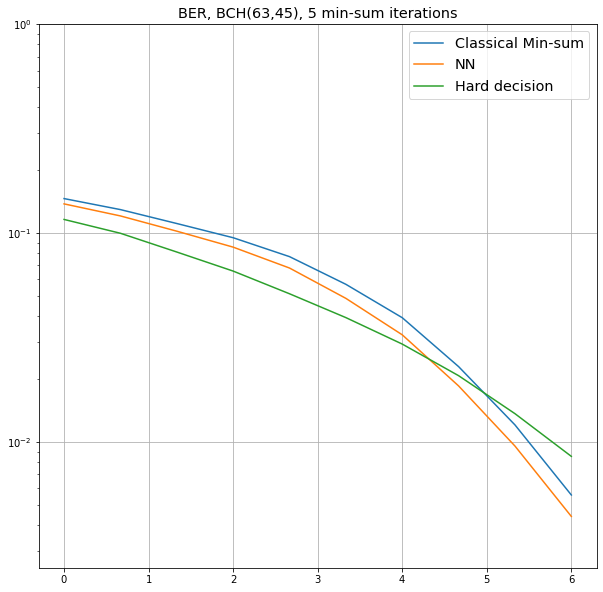

In [10]:
plt.figure(figsize=(10,10))
plt.semilogy(SNRs, bit_errors_min_sum.cpu() / nb_bits_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, bit_errors_nn.cpu() / nb_bits_nn.cpu(), label=f'NN')
plt.semilogy(SNRs, bit_errors_hard.cpu() / nb_bits_hard.cpu(), label='Hard decision')
plt.ylim([0.0025, 1])
plt.legend(fontsize='x-large')
plt.title('BER, BCH(63,45), 5 min-sum iterations', fontsize='x-large')
plt.grid()
plt.show()

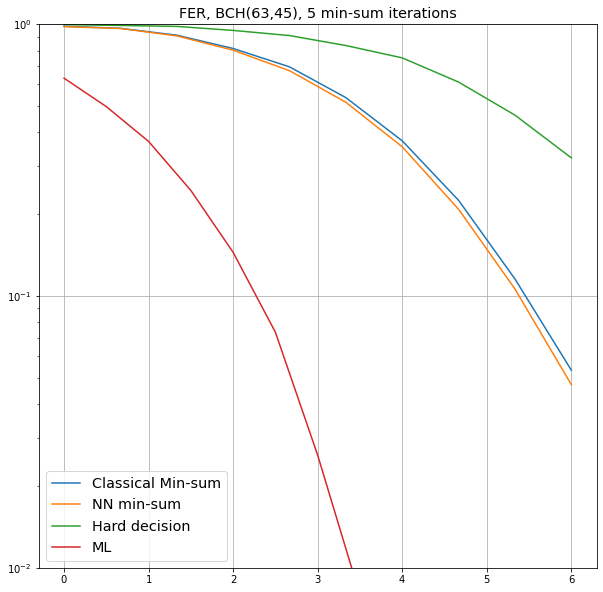

In [11]:
ml = np.loadtxt(f'source/BCH_{n}_{k}_ML.txt')

plt.figure(figsize=(10,10))
plt.semilogy(SNRs, frame_errors_min_sum.cpu() / nb_frames_min_sum.cpu(), label='Classical Min-sum')
plt.semilogy(SNRs, frame_errors_nn.cpu() / nb_frames_nn.cpu(), label=f'NN min-sum')
plt.semilogy(SNRs, frame_errors_hard.cpu() / nb_frames_hard.cpu(), label='Hard decision')
plt.semilogy(ml[:,0], ml[:,1], label='ML')
plt.ylim([0.01, 1])
plt.legend(fontsize='x-large')
plt.grid()
plt.title('FER, BCH(63,45), 5 min-sum iterations', fontsize='x-large')
plt.show()